# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 


The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
#Rubric: All the necessary packages and modules are imported in the first cell of the notebook

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from collections import OrderedDict
import json
import time
from PIL import Image

%matplotlib inline
from IPython.display import clear_output

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
# define input variables - training
batch_size = 64
epochs = 40
lr = 0.003
arch='vgg16'
data_dir = 'flowers'
n_hidden = [1024,512]
hidden_units = n_hidden
n_output = 102 # number of flower categories
save_dir = "."
gpu_train = True

In [3]:
# define input variables - testing
path_image = "./"
checkpoint_path = "./"
top_k = 5
category_names = 'cat_to_name.json'
gpu_test = True

In [4]:
# Rubric: torchvision transforms are used to augment the training data with random scaling,
#rotations, mirroring, and/or cropping
# Rubric: The training, validation, and testing data is appropriately cropped and normalized

# define transform for training set
# random scaling, rotations, mirroring, and/or cropping
def prepare_data(datapath, batch_size):
    batch_size = 64
    transf_train = transforms.Compose([transforms.Resize(255), \
                                        transforms.RandomResizedCrop(224), \
                                         transforms.RandomRotation(30), \
                                         transforms.RandomHorizontalFlip(), \
                                         transforms.ToTensor(), \
                                         transforms.Normalize([0.485,0.456,0.406], \
                                                              [0.229,0.224,0.225])])

    transf_test = transf_valid = transforms.Compose([transforms.Resize(255), \
                                      transforms.CenterCrop(224), \
                                      transforms.ToTensor(), \
                                      transforms.Normalize([0.485,0.456,0.406], \
                                                        [0.229, 0.224, 0.225])])

# Rubric: The data for each set (train, validation, test) is loaded with torchvision's ImageFolder
# load datasets
    data_train = datasets.ImageFolder(root=datapath+'/train', transform = transf_train)
    data_valid = datasets.ImageFolder(root=datapath+'/valid/', transform = transf_valid)
    data_test = datasets.ImageFolder(root=datapath+'/test/', transform = transf_test)
    
    return data_train, data_valid, data_test

In [5]:
# Rubric: The data for each set is loaded with torchvision's DataLoader    
# define dataloaders
def prepare_loader(data_train, data_valid, data_test, batch_size):
    loader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
    loader_valid = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, shuffle=True)
    loader_test = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=True)
    
    return loader_train, loader_valid, loader_test

In [6]:
data_train, data_valid, data_test = prepare_data(data_dir, batch_size)
loader_train, loader_valid, loader_test = prepare_loader(data_train, data_test, data_valid, batch_size)

In [7]:
print('Training dataset has {} elements, validation dataset has {} elements and \
testing dataset has {} elements'.format(len(loader_train.dataset), len(loader_valid.dataset), len(loader_test.dataset)))

Training dataset has 6552 elements, validation dataset has 819 elements and testing dataset has 818 elements


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [8]:
with open('cat_to_name.json') as json_file:
    cat_to_name = json.load(json_file)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [9]:
# Rubric: A pretrained network such as VGG16 is loaded from torchvision.models and the parameters are frozen

if arch == 'resnet50':
    model = models.resnet50(pretrained=True)
    n_inputs = 2048
else:
    model = models.vgg16(pretrained=True)
    n_inputs = 25088
    
# freeze feature parameters - do not backpropagate them
for param in model.parameters():
    param.requires_grad = False

In [10]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [11]:
def classifier(n_inputs, n_hidden, n_output):
    clf = nn.Sequential(OrderedDict([('fc1', nn.Linear(n_inputs, n_hidden[0])),
                                 ('relu1', nn.ReLU()),
                                 ('dropout1', nn.Dropout(p=0.2)),
                                 ('fc2', nn.Linear(n_hidden[0], n_hidden[1])),
                                 ('relu2', nn.ReLU()),
                                 ('dropout2', nn.Dropout(p=0.2)),
                                 ('fc3', nn.Linear(n_hidden[1], n_output)),
                                 ('log_softmax', nn.LogSoftmax(dim=1))]))
    torch.nn.init.kaiming_normal_(clf.fc1.weight, mode='fan_in')
    torch.nn.init.kaiming_normal_(clf.fc2.weight, mode='fan_in')
    torch.nn.init.kaiming_normal_(clf.fc3.weight, mode='fan_in')
    
    return clf

In [12]:
clf = classifier(n_inputs, n_hidden, n_output)

In [13]:
# update model with new classifier
if arch == 'resnet50':
    model.fc = clf
else:
    model.classifier = clf

In [14]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [15]:
# choose device 
#device = 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
# Rubric: The parameters of the feedforward classifier are appropriately trained, 
# while the parameters of the feature network are left static

# training parameters
# using negative Log-Likelihood as loss function
criterion = nn.NLLLoss()
# using Adam optimizer
if arch == 'resnet50':
    optimizer = optim.Adam(model.fc.parameters(), lr = 0.003)
else:
    optimizer = optim.Adam(model.classifier.parameters(), lr = 0.003)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [17]:
def train_model(model, criterion, optimizer, epochs, trainloader, validloader):
    train_losses = []
    valid_losses = []
    acc = []
    valid_step = batch_size
    step_valid = 0
    
    model.train()
    
    for e in range(epochs):
        start = time.time()
        train_loss = 0
        steps = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)        
            optimizer.zero_grad()
            logit = model.forward(inputs)
            loss = criterion(logit, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            steps += 1
            
            if steps % valid_step == 0:
        
                valid_loss = 0
                accuracy = 0
                with torch.no_grad():
                    model.eval()
                    for inputs, labels in validloader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logp = model(inputs)
                        loss = criterion(logp, labels)
                        valid_loss += loss.item()
                        prob = torch.exp(logp)
                        #top_p, top_class = prob.topk(1, dim=1) # returns just top_class
                        is_equal = (labels.data == prob.max(dim=1)[1])
                        accuracy += torch.mean(is_equal.type(torch.FloatTensor))
            
                step_valid += 1    
                model.train()

                # Rubric: During training, the validation loss and accuracy are displayed
                
                print("Epoch: {} of {}".format(e+1, epochs))
                print("Training loss = {:.3f}".format(train_loss/len(trainloader)))
                print("Validation loss = {:.3f}".format(valid_loss/len(validloader)))
                print("Validation Accuracy = {:.3f}".format(accuracy/len(validloader)))
                print(f"Time = {time.time()/60.:.3f}")
                acc.append(accuracy / len(validloader))
                valid_losses.append(valid_loss / len(validloader))
                train_losses.append(train_loss / len(trainloader))
        
                #save state for early stopping
                #torch.save(state, 'checkpoint_{}.pth'.format(e))
                
                
    return [train_losses, valid_losses, acc]

In [18]:
train_losses, valid_losses, acc = train_model(model, 
                                          criterion, 
                                          optimizer, 
                                          epochs, 
                                          loader_train, 
                                          loader_valid)

Epoch: 1 of 40
Training loss = 4.261
Validation loss = 3.886
Validation Accuracy = 0.163
Time = 25817574.267
Epoch: 2 of 40
Training loss = 2.121
Validation loss = 2.439
Validation Accuracy = 0.376
Time = 25817577.414
Epoch: 3 of 40
Training loss = 1.786
Validation loss = 2.295
Validation Accuracy = 0.430
Time = 25817580.559
Epoch: 4 of 40
Training loss = 1.635
Validation loss = 1.791
Validation Accuracy = 0.523
Time = 25817583.698
Epoch: 5 of 40
Training loss = 1.539
Validation loss = 1.631
Validation Accuracy = 0.563
Time = 25817586.833
Epoch: 6 of 40
Training loss = 1.443
Validation loss = 1.490
Validation Accuracy = 0.603
Time = 25817589.999
Epoch: 7 of 40
Training loss = 1.356
Validation loss = 1.454
Validation Accuracy = 0.621
Time = 25817593.153
Epoch: 8 of 40
Training loss = 1.347
Validation loss = 1.459
Validation Accuracy = 0.606
Time = 25817596.306
Epoch: 9 of 40
Training loss = 1.353
Validation loss = 1.313
Validation Accuracy = 0.646
Time = 25817599.470
Epoch: 10 of 40
Tra

Text(0,0.5,'Accuracy')

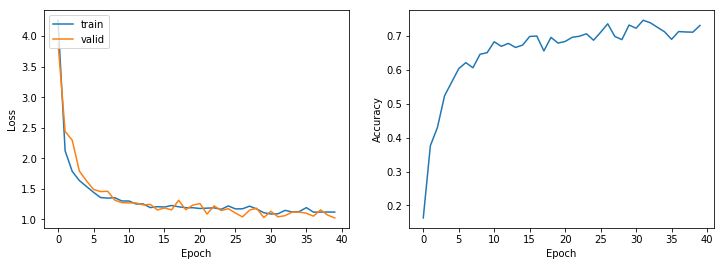

In [38]:
fig, axes = plt.subplots(figsize=(12,4), ncols=2)
axes[0].plot(train_losses, label='train')
axes[0].plot(valid_losses, label='valid')
axes[0].legend(loc='upper left')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[1].plot(acc)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [39]:
# Rubric: The network's accuracy is measured on the test data

def test_model(model, criterion, test_loader):
    ''''
    This function loads the trained model and evaluates its accuracy
    using the test set
    
    INPUTS:
    model - the pretrained model with the classifier
    criterion - loss function used for the training
    test_loader - Data loader containing test data
    
    OUTPUTS:
    test loss - mean loss calculated for testing set
    accuracy - mean accuracy calculated using the testing label
    '''
    
    model.to(device)
    
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            log_prob = model(inputs)
            loss = criterion(log_prob, labels)
            test_loss += loss.item()
            prob = torch.exp(log_prob)
            is_equal = (labels.data == prob.max(dim=1)[1])
            accuracy += torch.mean(is_equal.type(torch.FloatTensor))
                    
        model.train()
        
    return test_loss, accuracy

In [40]:
test_loss, accuracy = test_model(model, criterion, loader_test)
print("Test loss = {:.3f}".format(test_loss/len(loader_test)))
print("Test accuracy = {:.3f}".format(accuracy/len(loader_test)))

Test loss = 0.949
Test accuracy = 0.784


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [41]:
# Rubric: The trained model is saved as a checkpoint along 
# with associated hyperparameters and the class_to_idx dictionary

def saveModel(model, checkpoint_path, data_train):
    
    model.class_to_idx = data_train.class_to_idx
    checkpoint = {'input_size': n_inputs,\
              'hidden_size': n_hidden,\
              'output_size': n_output,\
              'conv_model': arch,\
              'class_to_idx': model.class_to_idx,\
              'state_dict': model.state_dict()}
    # class_to_idx is generated by datasets.ImageFolder and it maps the number of the folder
    # to the id the class has for the classifier.
   
    torch.save(checkpoint, checkpoint_path+'checkpoint.pth')

In [42]:
saveModel(model, checkpoint_path, data_train)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [43]:
# Rubric: There is a function that successfully loads a checkpoint and rebuilds the model

def loadModel(checkpoint, gpu_test):
    
    
    checkpoint = torch.load(checkpoint, map_location='cpu')
        
    if checkpoint['conv_model'] == 'vgg16':
        model = models.vgg16(pretrained=True)
    else:
        model = models.resnet50(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False
        
    n_inputs = checkpoint['input_size']
    n_hidden = checkpoint['hidden_size']
    n_output = checkpoint['output_size']
    
    clf = nn.Sequential(OrderedDict([('fc1', nn.Linear(n_inputs, n_hidden[0])),
                                 ('relu1', nn.ReLU()),
                                 ('fc2', nn.Linear(n_hidden[0], n_hidden[1])),
                                 ('relu2', nn.ReLU()),
                                 ('fc3', nn.Linear(n_hidden[1], n_output)),
                                 ('log_softmax', nn.LogSoftmax(dim=1))]))
      
    if checkpoint['conv_model'] == 'vgg16':
        model.classifier = clf
    else:
        model.fc = clf
    
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [44]:
model2 = loadModel(checkpoint_path+'checkpoint.pth', gpu_test)

In [45]:
model2.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [46]:
# Calculate test accuracy again for consistency
test_loss, accuracy = test_model(model2, criterion, loader_test)
print("Test loss = {:.3f}".format(test_loss/len(loader_test)))
print("Test accuracy = {:.3f}".format(accuracy/len(loader_test)))

Test loss = 0.942
Test accuracy = 0.786


**Note:** Original model and loaded model from checkpoint have same accuracy.

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [47]:
# Rubric: The process_image function successfully converts a 
# PIL image into an object that can be used as input to a trained model

def process_image(image):
    ''' 
     Scales, crops, and normalizes a PIL image for a PyTorch model, 
     returns an Numpy array
    '''
    
    img = Image.open(image)
    scale = transforms.Resize(255)
    crop = transforms.CenterCrop(224)
    toTensor = transforms.ToTensor()
    return toTensor(crop(scale(img))).numpy()

In [48]:
# using image 102.jpg to test function
img = process_image('102.jpg')
img

array([[[ 0.09411765,  0.09019608,  0.08235294, ...,  0.39215687,
          0.27843139,  0.21960784],
        [ 0.08235294,  0.09019608,  0.09411765, ...,  0.34901962,
          0.25098041,  0.22352941],
        [ 0.07450981,  0.08627451,  0.10588235, ...,  0.34117648,
          0.25882354,  0.24313726],
        ..., 
        [ 0.49803922,  0.51764709,  0.54901963, ...,  0.4509804 ,
          0.50588238,  0.52941179],
        [ 0.48235294,  0.50980395,  0.51372552, ...,  0.43921569,
          0.47843137,  0.49411765],
        [ 0.50196081,  0.50980395,  0.51372552, ...,  0.41176471,
          0.42745098,  0.43529412]],

       [[ 0.09411765,  0.08627451,  0.07450981, ...,  0.35294119,
          0.27058825,  0.23529412],
        [ 0.08235294,  0.08235294,  0.07843138, ...,  0.30588236,
          0.23137255,  0.22352941],
        [ 0.07450981,  0.07450981,  0.08627451, ...,  0.29019609,
          0.23137255,  0.23529412],
        ..., 
        [ 0.5529412 ,  0.55686277,  0.56470591, ...,

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [49]:
# Rubric: The predict function successfully takes the path to an image and a checkpoint, 
# then returns the top K most probable classes for that image

def predict(image, model, top_k=5):
    ''' 
        Predict the class (or classes) of an image using a trained deep learning model.
    
    '''
    model.to(device)

    print(device)
    img = Image.open(image)
    scale = transforms.Resize(255)
    crop = transforms.CenterCrop(224)
    toTensor = transforms.ToTensor()
    norm = transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])
    img_tensor = norm(toTensor(crop(scale(img)))).unsqueeze(dim=0)
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        output = model.forward(img_tensor)
        prob = torch.exp(output)
        top_prob, top_class = prob.topk(top_k, dim=1)
    
    top_prob = top_prob.detach().to('cpu').numpy().tolist()[0]
    top_class = top_class.detach().to('cpu').numpy().tolist()[0]
    
    return top_prob, top_class

In [31]:
top_prob, top_class = predict('102.jpg', model2, top_k)
top_prob, top_class

cuda


([0.9999847412109375,
  1.2664827409025747e-05,
  9.738591870700475e-07,
  6.792935547395018e-09,
  4.106825546301707e-09],
 [4, 58, 79, 99, 81])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. 

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [50]:
# Rubric: A matplotlib figure is created displaying an image and its 
# associated top 5 most probable classes with actual flower names

# This code was largely inspired by Josh Bernhard's blog post:
# https://medium.com/@josh_2774/deep-learning-with-pytorch-9574e74d17ad

def plot_prediction(image, model, top_k = 5):
    top_p, top_class = predict(image, model, top_k)
    img = process_image(image)
    # convert index to classes
    index_to_class = {j:i for i,j in model.class_to_idx.items()}
    # convert classes to labels
    topk = [cat_to_name[index_to_class[i]] for i in top_class]
    
    # plot figure
    fig, axes = plt.subplots(figsize=(12,4), ncols = 2)
    axes[0].imshow(img.transpose())
    axes[1].barh(topk, top_p)

cuda


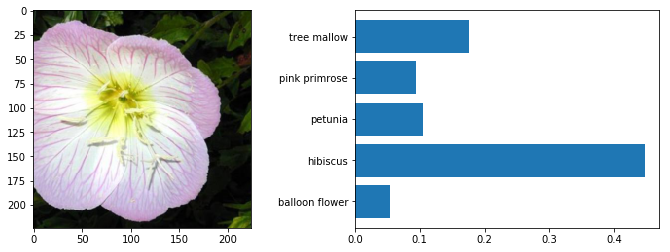

In [51]:
# testing with class 1 - 'pink primrose'
plot_prediction('1.jpg',model2)

cuda


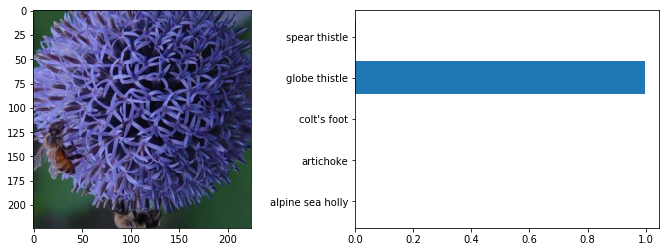

In [52]:
# testing with class 10 - 'globe thistle'
plot_prediction('10.jpg',model2)

cuda


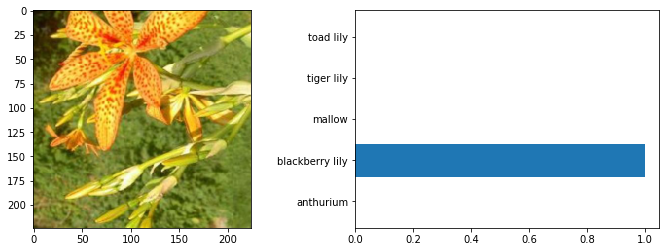

In [53]:
# testing with class 102 - 'blackberry lily'
plot_prediction('102.jpg',model2)

**Conclusion:** Training of VGG16 with the new classifier was well-succeded. Testing accuracy was 78.6% and it could predict the species of the test images used for sanity checking.

Interestingly, the classifier trained with Resnet50, which is a deeper network, gave worse results than VGG16.